In [9]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random as rn
import warnings
warnings.filterwarnings(action='ignore')


In [10]:
image_dir = Path('../input/boat-types-recognition')

In [11]:

image_files = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_files))
image_df = pd.DataFrame({'Filepath': image_files, 'Label': labels}).astype(str).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df

,Filepath,Label
0,../input/boat-types-recognition/gondola/venice...,gondola
1,../input/boat-types-recognition/kayak/canoe-wa...,kayak
2,../input/boat-types-recognition/paper boat/shi...,paper boat
3,../input/boat-types-recognition/kayak/lake-isl...,kayak
4,../input/boat-types-recognition/gondola/venice...,gondola
...,...,...
2919,../input/boat-types-recognition/sailboat/natur...,sailboat
2920,../input/boat-types-recognition/kayak/action-a...,kayak
2921,../input/boat-types-recognition/boats/gondola/...,gondola
2922,../input/boat-types-recognition/gondola/gondol...,gondola


In [12]:
image_df['Label'].value_counts()

sailboat           976
kayak              508
gondola            484
cruise ship        478
ferry boat         162
buoy               136
paper boat          80
freight boat        58
inflatable boat     42
Name: Label, dtype: int64

In [13]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [14]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

Found 2046 validated image filenames belonging to 9 classes.
Found 2046 validated image filenames belonging to 9 classes.
Found 878 validated image filenames belonging to 9 classes.


In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,validation_data=val_images, epochs=100,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)])


Epoch 1/100
64/64 [==============================] - 108s 2s/step - loss: 1.9510 - accuracy: 0.2870 - val_loss: 1.7766 - val_accuracy: 0.3372
Epoch 2/100
64/64 [==============================] - 75s 1s/step - loss: 1.7933 - accuracy: 0.3386 - val_loss: 1.7246 - val_accuracy: 0.3548
Epoch 3/100
64/64 [==============================] - 76s 1s/step - loss: 1.7181 - accuracy: 0.3679 - val_loss: 1.7167 - val_accuracy: 0.3568
Epoch 4/100
64/64 [==============================] - 76s 1s/step - loss: 1.7276 - accuracy: 0.3461 - val_loss: 1.6766 - val_accuracy: 0.3744
Epoch 5/100
64/64 [==============================] - 77s 1s/step - loss: 1.6497 - accuracy: 0.3736 - val_loss: 1.6430 - val_accuracy: 0.3900
Epoch 6/100
64/64 [==============================] - 76s 1s/step - loss: 1.6304 - accuracy: 0.3856 - val_loss: 1.6163 - val_accuracy: 0.3866
Epoch 7/100
64/64 [==============================] - 76s 1s/step - loss: 1.6100 - accuracy: 0.3951 - val_loss: 1.5998 - val_accuracy: 0.4233
Epoch 8/100


In [17]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.42438
Test Accuracy: 53.99%


In [18]:
model.summary()
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224  

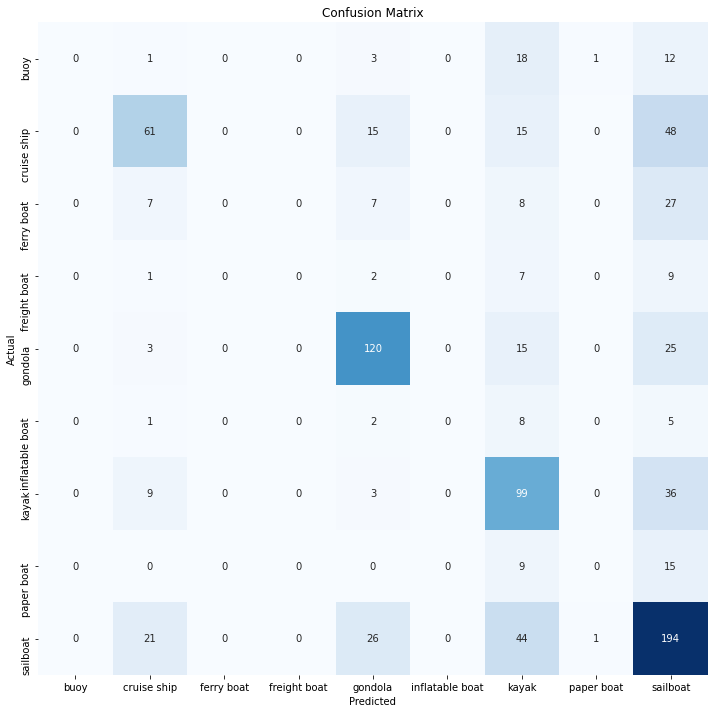

Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        35
    cruise ship       0.59      0.44      0.50       139
     ferry boat       0.00      0.00      0.00        49
   freight boat       0.00      0.00      0.00        19
        gondola       0.67      0.74      0.70       163
inflatable boat       0.00      0.00      0.00        16
          kayak       0.44      0.67      0.54       147
     paper boat       0.00      0.00      0.00        24
       sailboat       0.52      0.68      0.59       286

       accuracy                           0.54       878
      macro avg       0.25      0.28      0.26       878
   weighted avg       0.46      0.54      0.49       878



In [19]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=list(train_images.class_indices.keys()))

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [20]:
acc = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'MODEL ACCURACY')

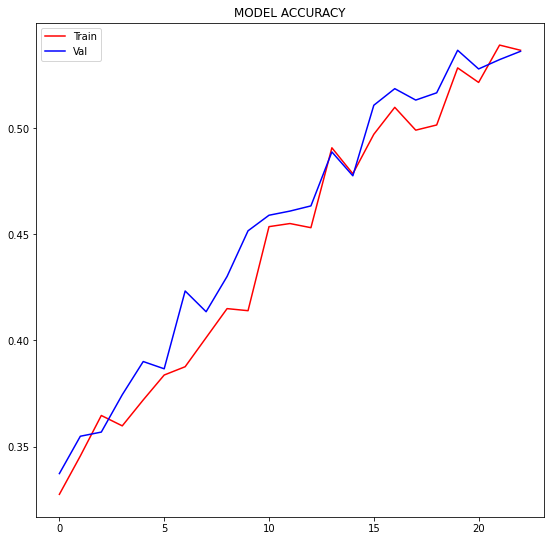

In [22]:
epochs_range = range(23)
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,'r', label='Train')
plt.plot(epochs_range, validation_accuracy,'b' ,label='Val')
plt.legend(loc='upper left')
plt.title('MODEL ACCURACY')

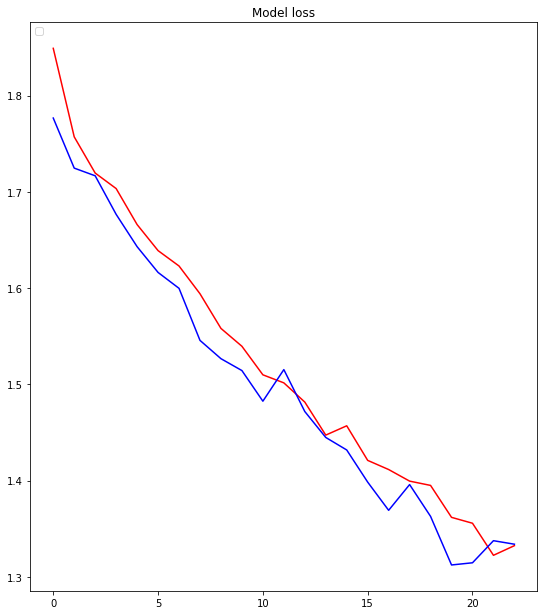

In [23]:
plt.figure(figsize=(20, 23))
plt.subplot(2, 2, 1)
plt.legend(loc='upper left')
plt.title('Model loss')
plt.plot(epochs_range, loss,'r', label='Train')
plt.plot(epochs_range, validation_loss,'b' ,label='Val')



In [24]:
Name0=[]
for dirname, _, filenames in os.walk('../input/boat-types-recognition'):
    Name0+=[dirname]

Name1=[]
for item in Name0:
    Name1+=[item[32:]]
                
Name2=[]
for item in Name1:
    if ('/' in item): 
        Name2+=[item[6:]]
        
Name3=sorted(Name2)

print(Name3)

['buoy', 'cruise ship', 'ferry boat', 'freight boat', 'gondola', 'inflatable boat', 'kayak', 'paper boat', 'sailboat']


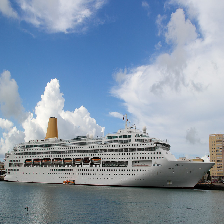

In [25]:
load_img("../input/boat-types-recognition/cruise ship/cadiz-andalusia-spain-travel-sky-3197928.jpg",
         target_size=(224,224,3))

In [27]:
image=load_img("../input/boat-types-recognition/cruise ship/cadiz-andalusia-spain-travel-sky-3197928.jpg",
               target_size=(224,224,3))

image=img_to_array(image) 
image=image/255
prediction_image=np.array(image)
prediction_image=np.expand_dims(image, axis=0)

In [28]:
reverse_mapping={ 0:Name3[0],1:Name3[1],2:Name3[2],3:Name3[3],4:Name3[4],5:Name3[5],6:Name3[6],7:Name3[7],8:Name3[8] }

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)

print("Prediction is {}.".format(move_name))

Prediction is sailboat.


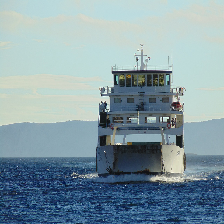

In [29]:
load_img("../input/boat-types-recognition/ferry boat/ferry-boat-water-sea-ship-croatia-1648809.jpg",
         target_size=(224,224,3))

In [30]:
image=load_img("../input/boat-types-recognition/ferry boat/ferry-boat-water-sea-ship-croatia-1648809.jpg",
               target_size=(224,224,3))

image=img_to_array(image) 
image=image/255
prediction_image=np.array(image)
prediction_image=np.expand_dims(image, axis=0)

In [31]:
reverse_mapping={ 0:Name3[0],1:Name3[1],2:Name3[2],3:Name3[3],4:Name3[4],5:Name3[5],6:Name3[6],7:Name3[7],8:Name3[8] }

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)

print("Prediction is {}.".format(move_name))

Prediction is sailboat.


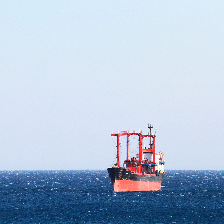

In [32]:
load_img("../input/boat-types-recognition/freight boat/ship-tanker-cargo-sea-2573453.jpg",
         target_size=(224,224,3))

In [33]:
image=load_img("../input/boat-types-recognition/freight boat/ship-tanker-cargo-sea-2573453.jpg",
               target_size=(224,224,3))

image=img_to_array(image) 
image=image/255
prediction_image=np.array(image)
prediction_image=np.expand_dims(image, axis=0)

In [34]:
reverse_mapping={ 0:Name3[0],1:Name3[1],2:Name3[2],3:Name3[3],4:Name3[4],5:Name3[5],6:Name3[6],7:Name3[7],8:Name3[8] }

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)

print("Prediction is {}.".format(move_name))

Prediction is sailboat.


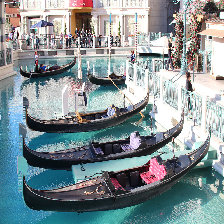

In [35]:
load_img("../input/boat-types-recognition/gondola/gondola-boat-las-vegas-venice-venetian-l-655864.jpg",
         target_size=(224,224,3))

In [36]:
image=load_img("../input/boat-types-recognition/gondola/gondola-boat-las-vegas-venice-venetian-l-655864.jpg",
               target_size=(224,224,3))

image=img_to_array(image) 
image=image/255
prediction_image=np.array(image)
prediction_image=np.expand_dims(image, axis=0)

In [37]:
reverse_mapping={ 0:Name3[0],1:Name3[1],2:Name3[2],3:Name3[3],4:Name3[4],5:Name3[5],6:Name3[6],7:Name3[7],8:Name3[8] }

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)

print("Prediction is {}.".format(move_name))

Prediction is gondola.


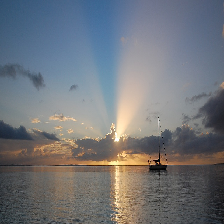

In [38]:
load_img("../input/boat-types-recognition/sailboat/boat-sunset-sea-sunbeam-sail-721937.jpg",
         target_size=(224,224,3))

In [39]:
image=load_img("../input/boat-types-recognition/sailboat/boat-sunset-sea-sunbeam-sail-721937.jpg",
               target_size=(224,224,3))

image=img_to_array(image) 
image=image/255
prediction_image=np.array(image)
prediction_image=np.expand_dims(image, axis=0)

In [40]:
reverse_mapping={ 0:Name3[0],1:Name3[1],2:Name3[2],3:Name3[3],4:Name3[4],5:Name3[5],6:Name3[6],7:Name3[7],8:Name3[8] }

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)

print("Prediction is {}.".format(move_name))

Prediction is kayak.


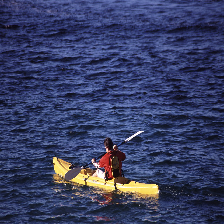

In [44]:
load_img("../input/boat-types-recognition/kayak/kayak-boat-paddling-kayaking-kayaker-kay-350476.jpg",
         target_size=(224,224,3))

In [45]:
image=load_img("../input/boat-types-recognition/kayak/kayak-boat-paddling-kayaking-kayaker-kay-350476.jpg",
               target_size=(224,224,3))

image=img_to_array(image) 
image=image/255
prediction_image=np.array(image)
prediction_image=np.expand_dims(image, axis=0)

In [46]:
reverse_mapping={ 0:Name3[0],1:Name3[1],2:Name3[2],3:Name3[3],4:Name3[4],5:Name3[5],6:Name3[6],7:Name3[7],8:Name3[8] }

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)

print("Prediction is {}.".format(move_name))

Prediction is cruise ship.
